# CAB420, DCNNs, Example 1: Classification with Deep Learning
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we will:
* Train a deep learning classifier to classify images
* Explore different layers, include fully connected and convoluational layers, and different activation functions

## Too Long; Didn't Read:
The main take home messages from this example are:
* We need to set out data up as the network expects it. That means that data and input shape must match, and for a classification network we need a categorical (one-hot vector) representation
* We can process images as a vector if we wish, but this disregards spatial information, and may not be the best approach to use.
* Convoluational networks allow us to learn over images (or other signals, as we'll see), and exploit spatial information
* Like other models, adding complexity for the sake of it may not always be for the best. Deep networks can overfit just like any other model

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import datetime
import numpy

import keras
from keras import layers

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

### A note about versions

You may have already encoutered this with other packages for CAB420, but it's worth noting here that the version of package that you use is important. On my builds, I'm running at least version 1.3.0 for sklearn and 2.15.0 for tensorflow, with using keras_core rather than any version of keras that's built into tensorflow. Earlier versions may not run the code we have here (or more likley other examples, as this one is pretty straight forward). If you start getting weird errors, one of the first things you check should be what version of key packages you are running.

In [2]:
print(sklearn.__version__)
print(keras.__version__)

1.4.0
3.0.4


## The Data
We'll use FashionMNIST. This is a built in dataset within keras/tensorflow, so we can load it directly through the keras API. This will also download the data the first time this is run.

Initially, we'll do a simple network that using a couple of fully connected layers and see how that works. To get the data into the format that we need, we'll flatten the data into vectors.

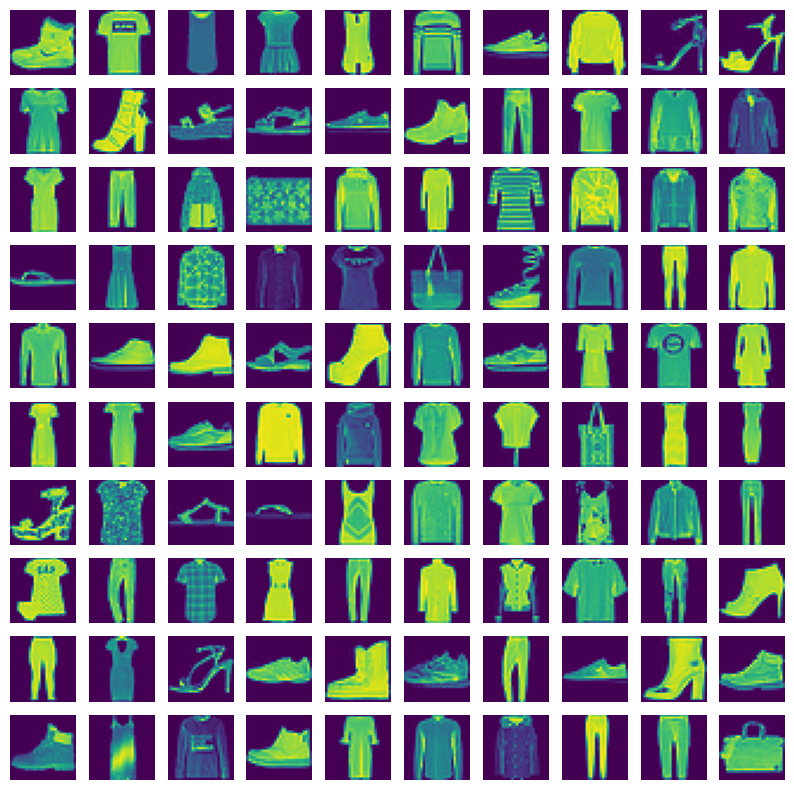

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:])
    ax.axis('off')
    
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

## Our First Model
We'll create a first neural network now. Throughout this example (and I suspect all others) I'm going to use the [functional API](https://keras.io/getting-started/functional-api-guide/) within Keras. This is not quite as simple as the [sequential models](https://keras.io/getting-started/sequential-model-guide/) within Keras, but it's far more powerful and it's still pretty easy to follow what's going on.

In [4]:
# create an input, we need to specify the shape of the input, in this case it's a vectorised images with a 784 in length
inputs = keras.Input(shape=(784,), name='img')
# first layer, a dense layer with 64 units, and a relu activation. This layer recieves the 'inputs' layer as it's input
x = layers.Dense(256, activation='relu')(inputs)
# second layer, another dense layer, this layer recieves the output of the previous layer, 'x', as it's input
x = layers.Dense(64, activation='relu')(x)
# output layer, length 10 units. This layer recieves the output of the previous layer, 'x', as it's input
outputs = layers.Dense(10, activation='softmax')(x)

# create the model, the model is a collection of inputs and outputs, in our case there is one of each
model = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_model')
# print a summary of the model
model.summary()

Model: "fashion_mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 256)               │    200,960 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 64)                │     16,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 10)                │        650 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 218,058 (851.79 KB)

 Trainable params: 218,058 (851.79 KB)

 Non-trainable params: 0 (0.00 B)

For clarify, we'll also draw some pictures of the model to help visualise the flow of data through the network.

The `plot_model` function has a bunch of options that you can use to make pretty plots of your networks - or just help understand what's going on. I've got this setup to:
* Show the output shape of the layer, so I can quickly check how the representation is changing as it moves through the network
* Show the activation, so I can check I've got this set to what I want and haven't missed something (like got the wrong activation at the output layer)
* Render at 80 dpi, as the default 200 is just a bit crazy on my display at least. You may want to adapt that value to suit yourself though.

There are a bunch of other [options for this function though](https://keras.io/api/utils/model_plotting_utils/#plot_model-function), which you may want to look at as our networks get more complex, but any more that what we have is probably overkill for this simple network.

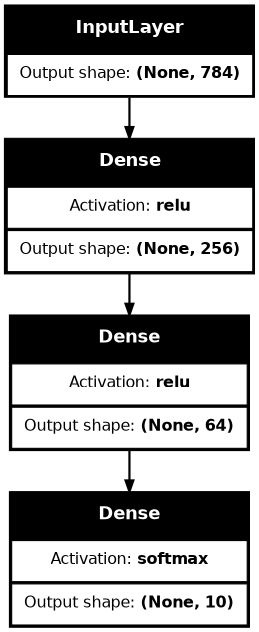

In [5]:
keras.utils.plot_model(model, show_shapes=True, dpi=80, show_layer_activations=True)

Next step is compiling the model. Here is where we specify our loss function (categorical cross entropy as we're doing multi-class classification), our optimiser (we're using Adam, but there are a lot of others we could use listed [here](https://keras.io/optimizers/)), and any metrics we want to track.

Once the model is compiled, we call fit to train the model. Here is where we specify things like our batch size, and the number of epochs that we wish to train for.

In [6]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'], jit_compile=False)
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_split=0.2)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7627 - loss: 0.6782 - val_accuracy: 0.8482 - val_loss: 0.4263
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8574 - loss: 0.3957 - val_accuracy: 0.8542 - val_loss: 0.4116
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8745 - loss: 0.3417 - val_accuracy: 0.8763 - val_loss: 0.3481
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8871 - loss: 0.3075 - val_accuracy: 0.8729 - val_loss: 0.3500
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8906 - loss: 0.2918 - val_accuracy: 0.8808 - val_loss: 0.3272
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9009 - loss: 0.2700 - val_accuracy: 0.8879 - val_loss: 0.3162
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9005 - loss: 0.2650 - val_accuracy: 0.8838 - val_loss: 0.3299
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9086 - loss: 0.2454 - val_accuracy: 0.

Our model is now trained, so we can now evaluate the model. We'll use Keras' inbuilt evaluation function, and then also plot a confusion chart to have a look at what's going on. Becuase I can, we'll also print out some metrics using sklearn's [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

Finally, we'll plot the training curves. What we're looking for in these is our training to have converged, i.e. to have stopped improving. If we don't train long enough, we'll see our training performance is still improving when we stop. If we train for too long, we may start to see overfitting and our validation performance going backwards. In these plots we are mostly interested in our performance on the validation set (our performance on unseen data), but we still want to check what's happening on the training set to make sure that we don't have something weird going on. We expect to see broadly similar trends for both training and validation sets, but better performance (and lower loss) on the training set.

In [7]:
def eval_model(model, history, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test, verbose=False);
    indexes = keras.ops.argmax(pred, axis=1)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
    print(classification_report(y_test, indexes))

    fig = plt.figure(figsize=[8, 4])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history['loss'], label='Training Loss')
    ax.plot(history['accuracy'], label='Training Accuracy')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.set_xlabel('Training Epochs')
    ax.set_ylabel('Accuracy or Loss')
    ax.legend()


Test loss: 0.3487095236778259
Test accuracy: 0.8898000121116638
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.80      0.78      0.79      1000
           3       0.90      0.88      0.89      1000
           4       0.76      0.86      0.81      1000
           5       0.98      0.97      0.97      1000
           6       0.76      0.68      0.72      1000
           7       0.96      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



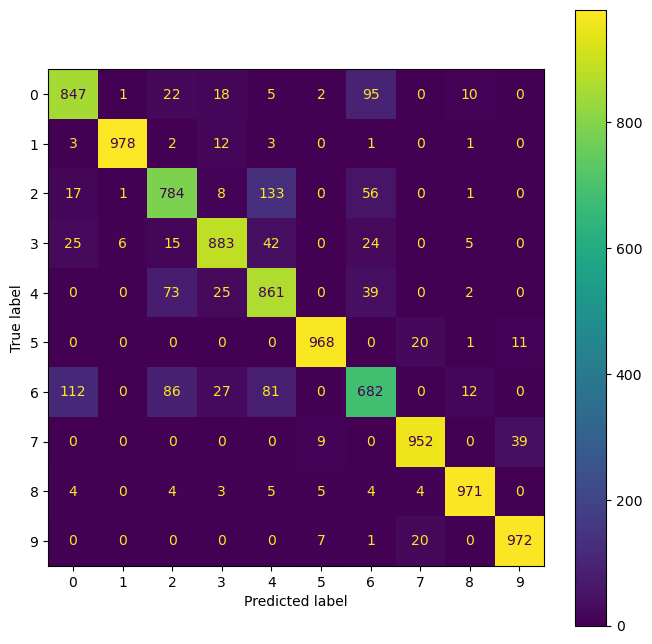

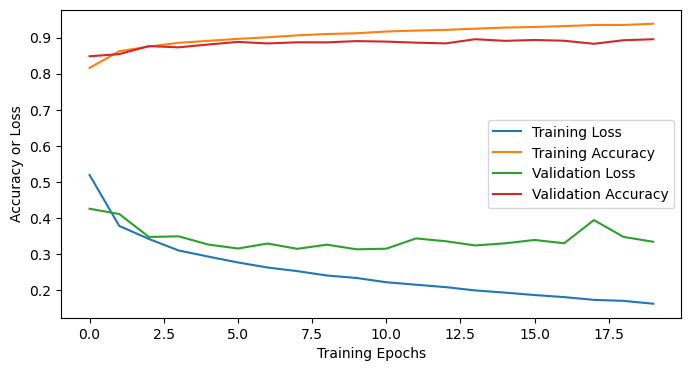

In [8]:
eval_model(model, history.history, x_test, y_test)

Our model works ok, but it's not great. Let's make it better.

## A CNN

We'll move to a CNN now and get this working better.
Given that we're going to use a CNN, we can use actual images, so we'll reload the data to get it back into the image shape that we want. Note that we also do a reshape on the data to get it into a 4D representation (samples, width, height, channels).

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

We'll build our model in much the same way as the first one, but just use different layers. Our key weapon here is the Conv2D (2D convolution) layer. We also have MaxPooling2D layers which are going to shrink our representation at various points throughout the network.

In [10]:
# our input now has a different shape, 28x28x1, as we have 28x28 single channel images
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
# rather than use a fully connected layer, we'll use 2D convolutional layers, 8 filters, 3x3 size kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
# 2x2 max pooling, this will downsample the image by a factor of two
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# more convolution, 16 filters, followed by max poool
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final convolution, 32 filters
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
# a flatten layer. Matlab does a flatten automatically, here we need to explicitly do this. Basically we're telling
# keras to make the current network state into a 1D shape so we can pass it into a fully connected layer
x = layers.Flatten()(x)
# a single fully connected layer, 64 inputs
x = layers.Dense(64, activation='relu')(x)
# and now our output, same as last time
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
model_cnn.summary()

Model: "fashion_mnist_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 32)          │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 288)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 64)                │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 10)                │        650 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 25,034 (97.79 KB)

 Trainable params: 25,034 (97.79 KB)

 Non-trainable params: 0 (0.00 B)

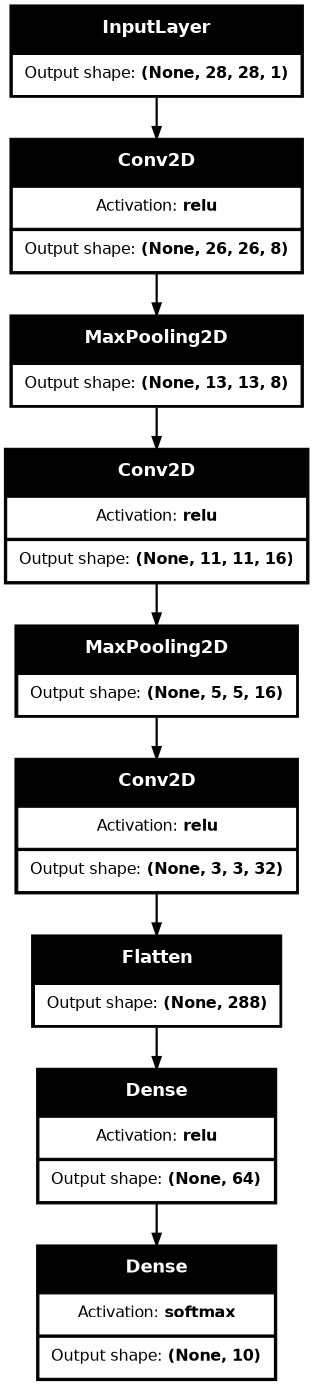

In [11]:
keras.utils.plot_model(model_cnn, show_shapes=True, dpi=80, show_layer_activations=True)

In [12]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=30,
                        validation_split=0.2)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6241 - loss: 1.0127 - val_accuracy: 0.8052 - val_loss: 0.5285
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8227 - loss: 0.4806 - val_accuracy: 0.8453 - val_loss: 0.4308
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8518 - loss: 0.4080 - val_accuracy: 0.8554 - val_loss: 0.3901
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8627 - loss: 0.3741 - val_accuracy: 0.8613 - val_loss: 0.3776
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8731 - loss: 0.3442 - val_accuracy: 0.8712 - val_loss: 0.3565
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8804 - loss: 0.3287 - val_accuracy: 0.8762 - val_loss: 0.3403
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8865 - loss: 0.3103 - val_accuracy: 0.8834 - val_loss: 0.3226
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8891 - loss: 0.2965 - val_accuracy: 0.

Test loss: 0.34735947847366333
Test accuracy: 0.8932999968528748
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       1.00      0.97      0.98      1000
           2       0.79      0.88      0.83      1000
           3       0.91      0.90      0.90      1000
           4       0.83      0.85      0.84      1000
           5       0.97      0.96      0.97      1000
           6       0.76      0.64      0.69      1000
           7       0.94      0.97      0.95      1000
           8       0.96      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



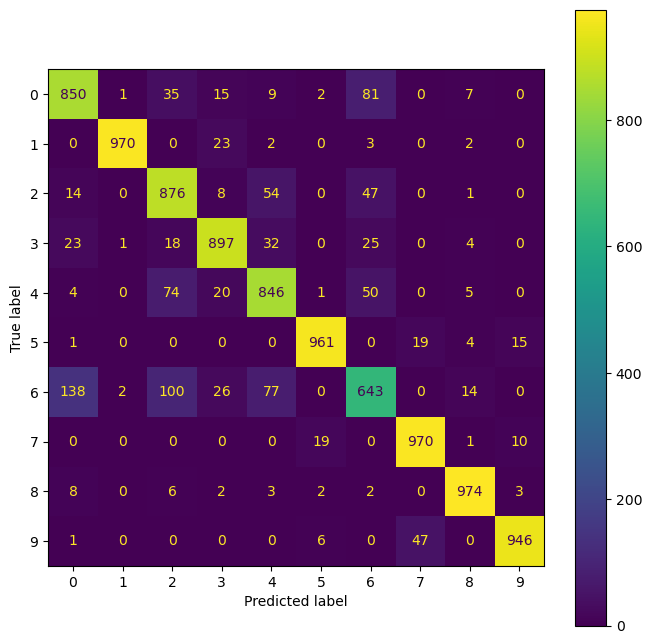

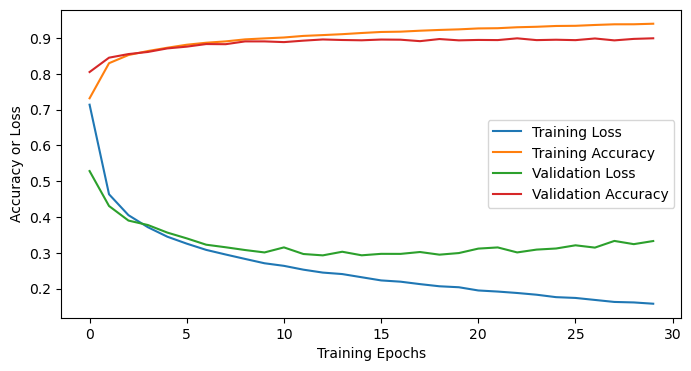

In [13]:
eval_model(model_cnn, history.history, x_test, y_test)

### SparseCategoricalCrossentropy(from_logits=False)?

We have the following above when we compile our network:

`model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])`
                  
What exactly are we doing here? Aren't we using regular categorical cross-entropy?

What we've done is taken a shortcut with our data wrangling. We have a 10 class problem, and so we have an output of size 10, where we expect the correct class to be set to 1, and all others 0 (a one-hot vector). Our target data though, is a list of numbers - i.e. we haven't converted it into a one-hot representation. Hence, we are using the `SparseCategoricalCrossentropy` loss which will do that conversion for us on the fly. If we had done the conversion, we would use regular `CategoricalCrossentropy`.

As for the `from_logits=False`, this comes down to whether we've applied a softmax layer or not at our output. If we haven't, then we'd set `from_logits=True` and again, our loss function would take care of the details for us and apply the softmax on the fly. For the sake of demonstration, we'll set the next model up with no softmax and use `from_logits=True`.

## Another Model
Let's crank it up a bit now. We'll add more convolutions, and add some batch norm and dropout (see `CAB420_DCNNs_Additional_Example_4_Layer_Order_and_Overfitting.ipynb` for details on those). Note that some of the dropout is not really needed here (we're not particularly overfitting), but for demonstration purposes it is included.

In [14]:
# our model, input again, still in an image shape
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
# run pairs of conv layers, all 3s3 kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
# batch normalisation, before the non-linearity
x = layers.BatchNormalization()(x)
# spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
# than dropping out 20% of the invidual pixels
x = layers.SpatialDropout2D(0.2)(x)
# max pooling, 2x2, which will downsample the image
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# rinse and repeat with 2D convs, batch norm, dropout and max pool
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final conv2d, batch norm and spatial dropout
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
# flatten layer
x = layers.Flatten()(x)
# we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
# in the middle
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
# the output
outputs = layers.Dense(10, activation=None)(x)

# build the model, and print a summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
model_cnn.summary()

Model: "fashion_mnist_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 8)         │        584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 28, 28, 8)         │         32 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d               │ (None, 28, 28, 8)         │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 16)        │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 14, 14, 16)        │         64 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_1             │ (None, 14, 14, 16)        │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 32)          │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 32)          │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 7, 7, 32)          │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_2             │ (None, 7, 7, 32)          │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 256)               │    401,664 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 64)                │     16,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 10)                │        650 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 437,026 (1.67 MB)

 Trainable params: 436,914 (1.67 MB)

 Non-trainable params: 112 (448.00 B)

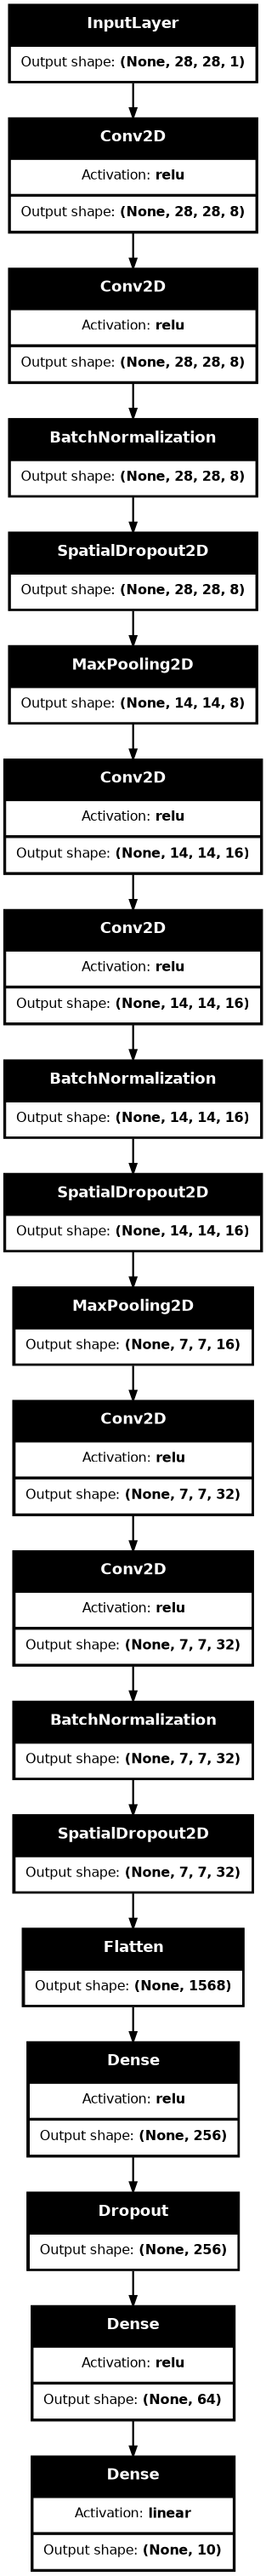

In [15]:
keras.utils.plot_model(model_cnn, show_shapes=True, dpi=80, show_layer_activations=True)

Compile and train the model

In [16]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=40,
                        validation_split=0.2)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6637 - loss: 0.9557 - val_accuracy: 0.8528 - val_loss: 0.3926
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8310 - loss: 0.4753 - val_accuracy: 0.8711 - val_loss: 0.3502
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8506 - loss: 0.4181 - val_accuracy: 0.8752 - val_loss: 0.3448
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8652 - loss: 0.3783 - val_accuracy: 0.8745 - val_loss: 0.3384
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8662 - loss: 0.3732 - val_accuracy: 0.8907 - val_loss: 0.3029
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8717 - loss: 0.3560 - val_accuracy: 0.8725 - val_loss: 0.3518
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8769 - loss: 0.3604 - val_accuracy: 0.8917 - val_loss: 0.3016
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8811 - loss: 0.3382 - val_accuracy: 0

Test loss: 0.27019640803337097
Test accuracy: 0.9139000177383423
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.84      0.90      0.87      1000
           3       0.90      0.92      0.91      1000
           4       0.87      0.85      0.86      1000
           5       0.99      0.98      0.98      1000
           6       0.80      0.70      0.75      1000
           7       0.94      0.98      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



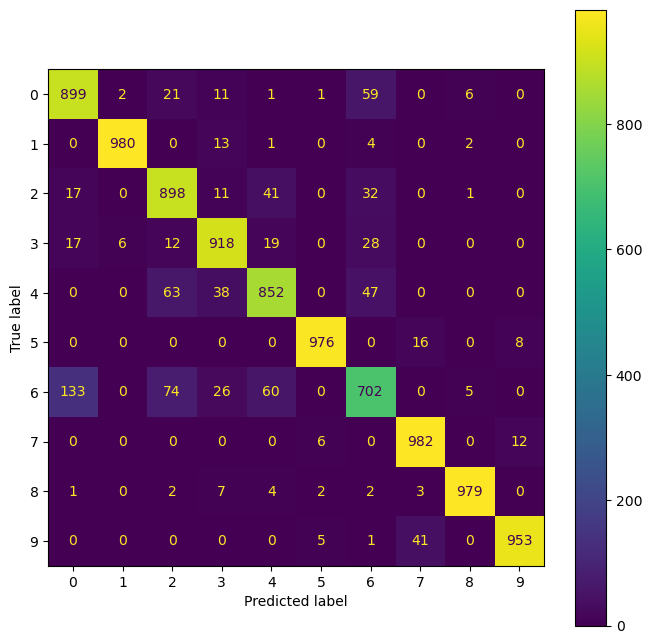

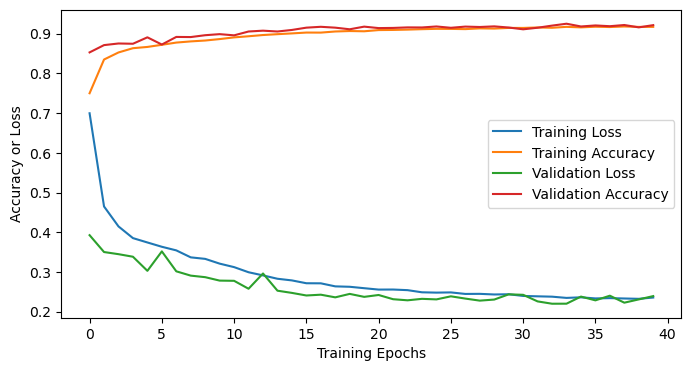

In [17]:
eval_model(model_cnn, history.history, x_test, y_test)

Our final model is working a bit better again, but it is a lot bigger. It's worth noting the size increase here and the performance gain (or lack of) that goes with it. 

With DCNNs there are very much some diminishing returns going on. We can make our networks bigger and bigger, and while they will get better, the rate of improvement is really quite small compared to the increase in complexity that comes with it.

## Final Thoughts

In this example we've seen:
* How to train a deep neural network
* The difference between a simple fully connected feed-forward network, and a convolutional network
* How convoluational layers can be 'stacked' to increase computation power
* That deep networks aren't fast to train

Note that, as is often the case, we've not really used a validation set. Rather we've trained for a fixed number of epochs and stopped at that point. The other approach with deep nets is to, using a validation set, train for a fixed number of epochs and take the best performing set across all epochs on the validation set, and apply that model to the test set. This guards against overfitting as if the network starts to overfit and performance on the validation set drops, we end up taking the version of the network that performed best on the validation network before things overfit. This is actually really easy to do in Keras with a [callback](https://keras.io/callbacks/#modelcheckpoint) if you so wish.

Note also that we haven't really trained to convergence either. We could afford to let these models run longer, which we can easily do by increasing the number of epochs. The only real reason I haven't done this is for the sake of run-times.